# Week 8: Corner Detection


### Date : 9nd December, 2021

Last week you learned about corner detection algorithms and how these can be used to find
interesting features on an image that can be used in applications such as stereo matching,
3D reconstruction, tracking, localization and recognition.
Your task today is to code two corner detection algorithms, the Moravec and the Harris
corner detector.

In [1]:
import numpy as np
import copy
import cv2
from matplotlib import pyplot as plt
import random
from PIL import Image
from utils import draw_corners, load_image, apply_kernel, get_gaussian_filter
# to visualize the plots within the notebook
%matplotlib inline
# for making plots looking nicer
plt.style.use('fivethirtyeight')


In [61]:
def non_maximum_suppression(img, threshold, n=7):
  """
  Return a list of coordinates such that img[coordinate] > threshold and
  img[coordinate] is the maximum in the nxn neighborhood.
  """
  assert len(img.shape) == 2
  maxs = np.zeros_like(img)
  assert n % 2 == 1
  half_n = n // 2
  for nx in range(-half_n, half_n + 1):
    for ny in range(-half_n, half_n + 1):
      vals = np.roll(img, (-nx, -ny), (1, 0))
      maxs = np.maximum(maxs, vals)
  return [
    (y, x)
    for y in range(img.shape[0])
    for x in range(img.shape[1])
    if img[y, x] > threshold and img[y, x] == maxs[y, x]
  ]

## Task 1: Moravec corner detector

The Moravec corner detector uses a window centred on each pixel as its own matching
template.
The window is shifted so that it is centred on each of the 8 neighbours of the pixel
and the sum of squared differences (SSD) is calculated between the original window and the
shifted window.
For every window shifted by $\Delta x$ and $\Delta x$, the SSD is:

$$
    \epsilon (\Delta x, \Delta y) = \sum_{(x,y)\in N_{3 \times 3}(x_0,y_0)} w(x,y)(I(x + \Delta x, y + \Delta y) - I(x,y))^2
$$


$w(x,y)$ is a weighting function, you can use a Gaussian or constant weights.


The corner metric (cornerness) is then taken to be the minimum of the SSD values calculated for each of the eight shifts of the window.
A pixel is marked as a corner if its cornerness is above a user-specified threshold.


Your task is to write your implementation of the Moravec corner detector.
It will take as input a greyscale image, the window size, the threshold and optionally a Gaussian function for $w(x,y)$.
It will give as output a corner map as a list of locations $(x,y)$ where a corner is detected.

**Note:** make use of the helper functions in util.py already loaded for you. Take a minute to understand how they work and what input and output to expect.

In [53]:
def moravec(image, window_size: int = 1, threshold=100, weights=None):
    """Moravec's corner detection for each pixel of the image."""

    assert len(image.shape) == 2, "Color not supported"

    if weights is None:
        weights = np.ones((window_size, window_size))
    assert window_size % 2 == 1
    assert weights.shape == (window_size, window_size)

    values = None
    k_half_size = int(window_size / 2)
    for dx in range(-1, 2):
        for dy in range(-1, 2):
            if dx == 0 and dy == 0:
                continue
            ssd = np.zeros(image.shape)
            for kx in range(-k_half_size, k_half_size+1):
                for ky in range(-k_half_size, k_half_size+1):
                    w = weights[ky+k_half_size, kx+k_half_size]
                    k_vals_center = w * np.roll(image, (-kx, -ky), (1, 0))
                    k_vals_shifted = w * \
                        np.roll(image, (-(kx + dx), -(ky + dy)), (1, 0))
                    ssd += (k_vals_center - k_vals_shifted)**2
            if values is None:
                values = ssd
            else:
                values = np.minimum(values, ssd)

    plt.imshow(np.log(values))

    return non_maximum_suppression(values, threshold)


/tmp/ipykernel_2060/3799055709.py:30: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(values))


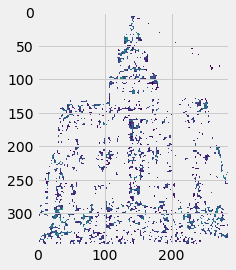

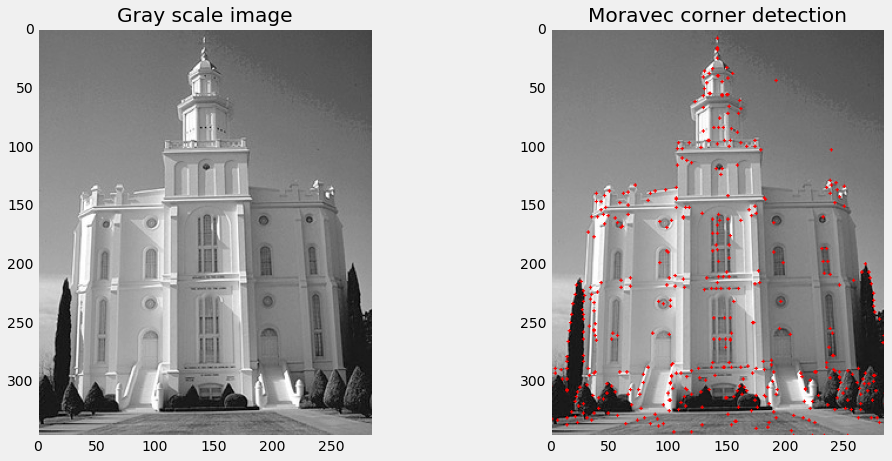

In [62]:
threshold = 100
gray_img = load_image('../images/building.png')

# replace with your code
moravec_corners = moravec(gray_img, window_size=1, threshold=threshold)

img_with_corner = draw_corners(gray_img.reshape((*gray_img.shape, 1)), moravec_corners)

# Show Original and detected corners on image
fig, axis = plt.subplots(1, 2, figsize=(15, 7), sharey=False)
#fig.subplots_adjust(wspace=-0.2, hspace=0.0)
axis[0].imshow(gray_img, 'gray')
axis[0].grid(False)
axis[0].set_title('Gray scale image')

axis[1].imshow(img_with_corner, 'gray')
axis[1].grid(False)
axis[1].set_title('Moravec corner detection')

plt.show()


## Task 2: Harris corner detector

The Harris corner detector builds upon the concepts of the Moravec corner detector, but
overcomes its limitations by generalising the measure of cornerness.
The basic limitation of the Moravec detector is that it only calculates cornerness for the 8 main directions
corresponding to the neighbours of a pixel, which means it will not detect a corner in any other direction.
The Harris detector uses the image structure tensor to overcome this. The image structure tensor is:

$$
    S(I_x, I_y) = 
    \begin{pmatrix}
     <I^2_x>   & <I_x I_y>\\
     <I_x I_y> & <I^2_x>
    \end{pmatrix}
$$

where $I_x$ is the partial derivative of the image in the $x$ direction and $I_y$ is the partial derivative of the image in the $y$ direction.
The structure tensor summarizes the main directions of the gradient of the image for every pixel and therefore its two eigenvalues can be used to determine whether there is a corner at a pixel (if both eigenvalues are large).
The cornerness metric is then defined as the size of the smallest eigenvalue, or the fraction of the tensor’s determinant over the tensor’s trace (to avoid the expensive calculation of the actual eigenvalues):

$$
    C = det(S)/Tr(S) \\
    C = (<I^2_x><I^2_y> - <I_x I_y>)/(<I^2_x> + <I^2_y>)
$$

A pixel is then marked as a corner if its cornerness is above a user-specified threshold.

Your task is to write your implementation of the Harris corner detector.
It will take as input a greyscale image, the window size and the threshold.
It will give as output a corner map as a list of locations $(x,y)$ where a corner is detected.

**Note:** make use of the helper functions in util.py already loaded for you. Take a minute to understand how they work and what input and output to expect.

In [56]:
def harris(image, window_size: int = 1, threshold=100, weights=None):
    """Harris's corner detection for each pixel of the image."""

    Gy, Gx = np.gradient(image)
    Gxy = Gy * Gx
    Gxx = Gx**2
    Gyy = Gy**2

    C = (Gxx * Gyy - Gxy) / (Gxx + Gyy)

    return non_maximum_suppression(C, threshold)


/tmp/ipykernel_2060/1951908776.py:9: RuntimeWarning: invalid value encountered in true_divide
  C = (Gxx * Gyy - Gxy) / (Gxx + Gyy)


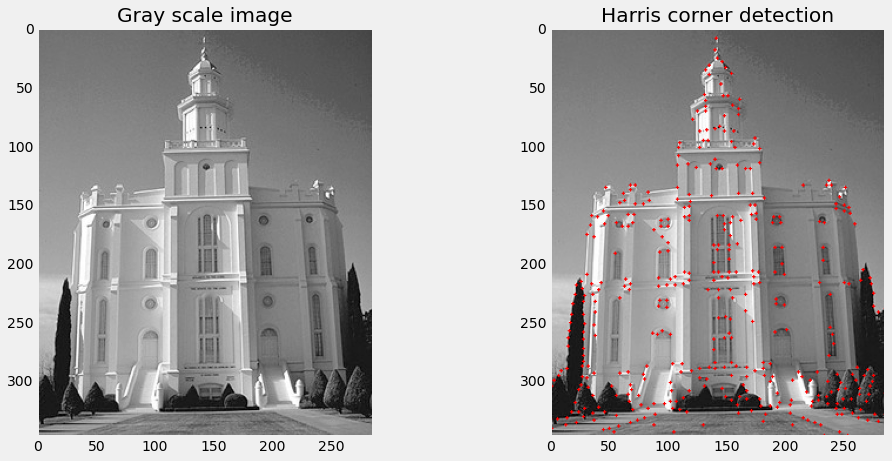

In [63]:
threshold = 100

img = load_image('../images/building.png')

# replace with your code
harris_corners = harris(img, threshold=threshold)

harris_img_corner = draw_corners(img.reshape((*img.shape, -1)), harris_corners)

# Show Original and detected corners on image
fig, axis = plt.subplots(1, 2, figsize=(15, 7), sharey=False)
#fig.subplots_adjust(wspace=-0.2, hspace=0.0)
axis[0].imshow(img, 'gray')
axis[0].grid(False)
axis[0].set_title('Gray scale image')

axis[1].imshow(harris_img_corner, 'gray')
axis[1].grid(False)
axis[1].set_title('Harris corner detection')

plt.show()
